# Configs

In [ ]:
import random


random.seed(27)

splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Load data

In [ ]:
from utils.prepare_data import getMonitoredPatients
from pandas import Timedelta


patients = getMonitoredPatients()
patients.removePatientAkiEarly(Timedelta(hours=12))

print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

1213

# Transformer

### Seperate static and dynamic

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SplitTransformer(nn.Module):
    def __init__(self, timeSteps, timeFeatures, staticFeatures):
        super(SplitTransformer, self).__init__()

        self.timeSteps = timeSteps
        self.timeFeatures = timeFeatures
        self.staticFeatures = staticFeatures

        # time series layers
        self.transformerEncoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=timeFeatures, nhead=2, dim_feedforward=256, batch_first=True
            ),
            num_layers=2,
        )
        
        # static layers
        self.fc2_1 = nn.Linear(staticFeatures, 16)
        
        # combine layers
        self.fc1 = nn.Linear(timeSteps + 16, 16)
        self.fc2 = nn.Linear(16, 1)
        
    def forward(self, seriesInput, staticInput):
        seriesLayer = self.transformerEncoder(seriesInput)
        seriesLayer = F.adaptive_max_pool1d(seriesLayer, 1)
        
        staticLayer = F.relu(self.fc2_1(staticInput))        
        
        combined = torch.cat([seriesLayer.squeeze(-1), staticLayer], dim=1)
        combined = F.relu(self.fc1(combined))
        combined = self.fc2(combined)
        
        return combined

model = SplitTransformer(12, 16, 67)
sample_series_input = torch.randn(1, 12, 16)  # (batch_size, timeSteps, timeFeatures)
sample_static_input = torch.randn(1, 67)
_ = model(sample_series_input, sample_static_input)
print(model)

del model
del sample_series_input
del sample_static_input

torch.Size([1, 28]) torch.Size([1, 12, 1]) torch.Size([1, 16])
SplitTransformer(
  (transformerEncoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc2_1): Linear(in_features=67, out_features=16, bias=True)
  (fc1): Linear(in_features=28, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


### Train and eval

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from utils.class_voter import combineProbas
from utils.dl_train_test import predTest, train
from utils.prepare_data import (
    DeepLearningDataPreparer,
    trainValTestPatients,
)
import numpy as np


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 64

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        (
            (npTrainX, staticTrainX, trainY),
            (npValX, staticValX, valY),
            (npTestX, staticTestX, testY),
        ) = preparer.trainValTest(trainPatients, valPatients, testPatients)

        # neg, pos = np.bincount(trainY)
        # weight0 = (1 / neg) * (len(trainY)) / 2.0
        # weight1 = (1 / pos) * (len(trainY)) / 2.0
        # weight = {0: weight0, 1: weight1}

        # expand static data to be same size as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)
        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        # create data loader
        trainLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTrainX).float(),
                torch.tensor(trainY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=True,
        )
        valLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npValX).float(),
                torch.tensor(valY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )
        testLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTestX).float(),
                torch.tensor(testY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )

        model = SplitTransformer(
            timeSteps=npTrainX.shape[1],
            timeFeatures=npTrainX.shape[2],
            staticFeatures=staticTrainX.shape[2],
        )
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

        _, trainLosses, valLosses = train(
            model,
            device,
            trainLoader,
            valLoader,
            criterion,
            optimizer,
            epochs=50,
            earlyStopping=10,
        )

        models.append(model)
        train_loss_list.append(trainLosses)
        val_loss_list.append(valLosses)

        predProbas, _ = predTest(model, device, testLoader)
        probas.append(predProbas)
        torch.save(model.state_dict(), f"result/transformer_only_model/{i}_{ii}.pt")

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

I0000 00:00:1726443190.071385 3082543 service.cc:146] XLA service 0x7e0964018960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726443190.071406 3082543 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-09-16 06:33:10.115668: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-16 06:33:10.140407: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. split_transfomer_1_1/transformer_encoder_1/layer_0/self_attention/dropout_3/dropout/random_uniform/RandomUniform
2024-09-16 06:33:10.519930: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-16 06:33:11.018531: I external

1/8 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step

2024-09-16 06:33:41.424826: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 416 bytes spill stores, 408 bytes spill loads

2024-09-16 06:33:41.487537: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 12 bytes spill stores, 12 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


2024-09-16 06:51:58.302762: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 20 bytes spill stores, 20 bytes spill loads

2024-09-16 06:51:58.356913: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 236 bytes spill stores, 236 bytes spill loads



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


In [14]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.8126984731904349 +- 0.011667640492285514 [0.8299319727891156, 0.8075178789464503, 0.8155886942951275, 0.8161088954395699, 0.7943449244819109]
Accuracy: 0.7526547619047619 +- 0.02343757220531417 [0.7955555555555556, 0.7333333333333333, 0.76, 0.7377777777777778, 0.7366071428571429]
Specificity: 0.7335942596216569 +- 0.03871963219125499 [0.7755102040816326, 0.7006802721088435, 0.7808219178082192, 0.726027397260274, 0.684931506849315]
Precision: 0.6148411980575281 +- 0.03153716741333896 [0.6632653061224489, 0.5849056603773585, 0.6404494382022472, 0.6, 0.5855855855855856]
Recall: 0.788510223953262 +- 0.04333238509056397 [0.8333333333333334, 0.7948717948717948, 0.7215189873417721, 0.759493670886076, 0.8333333333333334]
AUC PR: 0.6917546739592506 +- 0.02570981691606199 [0.6878233740323112, 0.6778479267393064, 0.717475982620045, 0.7224790356636395, 0.653147050740951]


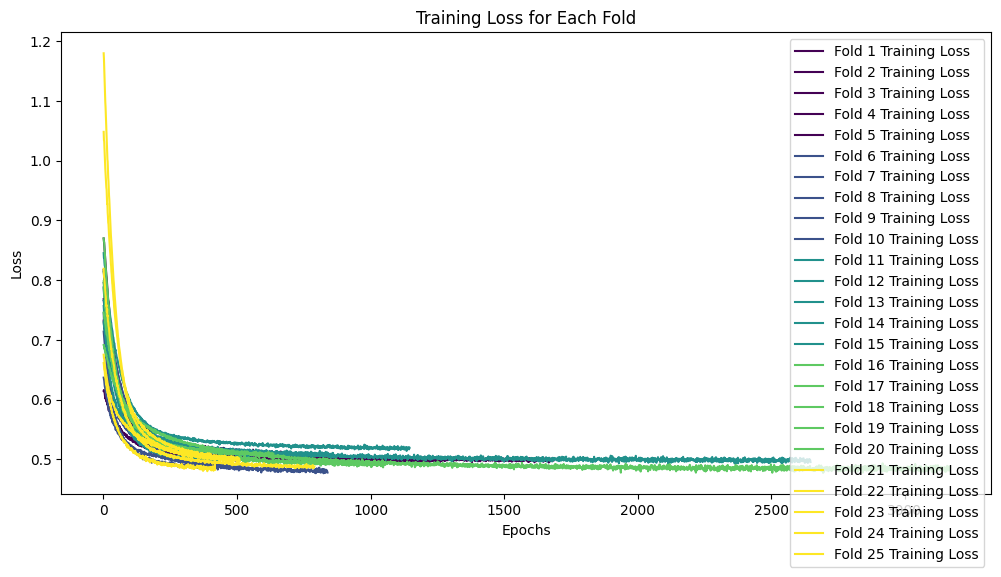

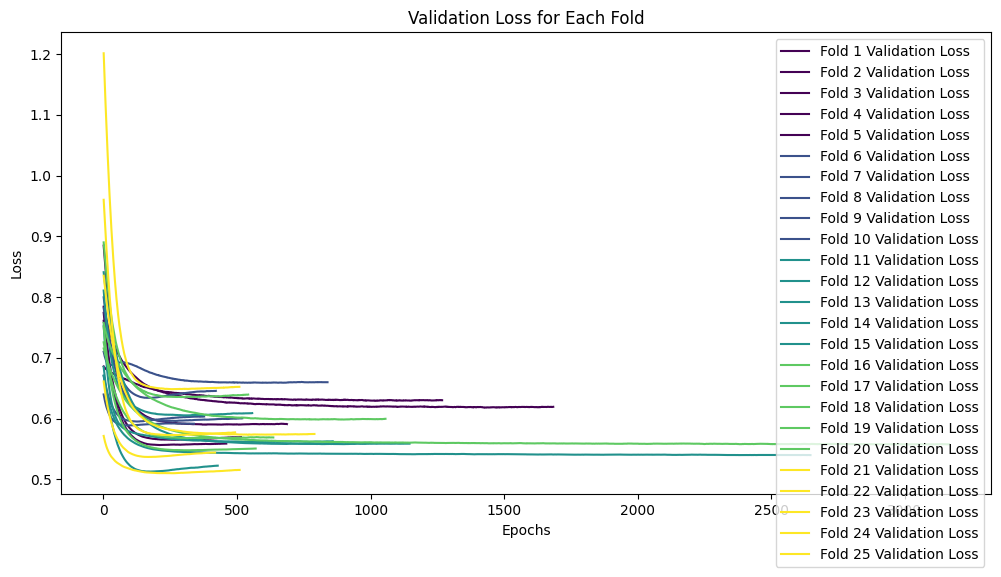

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm 


plt.figure(figsize=(12, 6))

colors = cm.viridis(np.linspace(0,1,5))

for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_split_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_split_val_loss.svg")
plt.show()